<a href="https://colab.research.google.com/github/Rrivera2003/Hands-On_Machine_Learning-/blob/main/Chapter_3/Classification_Chap3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Classification

And let's create the images/classification folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res for the book:

In [1]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST  
In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.  
Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset from OpenML.org:

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The sklearn.datasets package contains mostly three types of functions: fetch_* functions such as fetch_openml() to download real-life datasets, load_* functions to load small toy datasets bundled with Scikit-Learn, and make_* functions to generate fake datasets useful for tests.

The fetch_openml() function is a bit unusual since by default it returns the inputs as a Pandas DataFrame and the labels as a Pandas Series (unless the dataset is sparse). But the MINST dataset contains images, and DataFrames arent ideal for that, so its preferable to set as_frame=False to get the data as NumPy arrays instead. Let's look at these arrays:

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28 x 28 pixels, and each feature simply represents one pixel's intensity from 0 (white) to 255 (black). Let's take a peek at one digit from the dataset. All we need to do is grab an instance's feature vector, reshape it to a 28 x 28 array, and display it using Matplotlib's imshow() function. We use a cmap="binary" to get a grayscale color map where 0 is white and 255 is black:

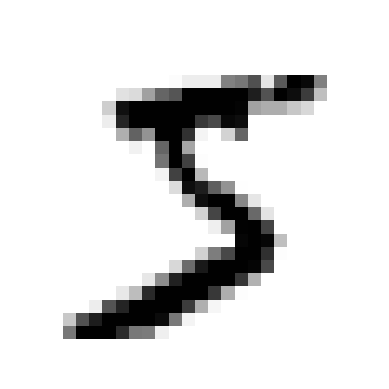

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

This looks like a 5, and indeed that's what the label tells us:

In [8]:
y[0]

'5'

We should always create a test set and set it aside before inspecting the data closely. The MNIST dataset returned by fetch_openml() is actually already split into a training set(the first 60,000 images) and a test set (the last 10,000 images):

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds, will be similar (we dont want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the data ensures that this won't happen.

### Training a Binary Classifier  
Let's simplify the problem for now and only try to identify one digit-for example the number 5. This "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5. First we'll create the target vectors for this classification task:

In [10]:
y_train_5 = (y_train == '5') #True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Now let's pick a classifier and train it. A good place to start is with a stochastic gradient descent (SGD) classifier, using Scikit-Learn's SGDClassifier class. This classifier is capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning, as we will see later. Let's create an SGDClassifier and train it on the whole training set:

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:

In [12]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case.

## Performance Measures

### Measuring Accuracy Using Cross-Validation  
A good way to evaluate a model is to use cross-validation, just as we did in Chapter 2. Let's use the cross_val_score() function to evaluate our SGDClassifier model, using k-fold cross-validation with three folds. Remember that k-fold cross-validation means splitting the training set into k folds (in this case 3), then training the model k times, holding out a different fold each time for evaluation:

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Above 95% accuracy (ratio of correct predictions) on all cross-validation folds?
Before we get too excited, lets look at a dummy classifier that just classifies every single image in the most frequent class, which is in this case is the negative class (i.e., non 5):

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected

False


Lets see this models accuracy:

In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

It has over 90% accuracy. This is simply because only about 10% of the images are 5s, so if we always guess that an image is not a 5, we will be right about 90% of the time.  
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when we are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

### Confusion Matrices  
The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs. For example, to know the number of times the classifier confused images of 8s with 0s, we would look at row #8, column #0 of the confusion matrix.  
To compute the confusion matrix, we first need to have a set of predictions so that they can be compared to the actual targets. We could make predictions on the test set, but it's best to keep that untouched for now. Instead,we can use the cross_val_predict() function:

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.  
Now we are ready to get the confusion matrix using the confusion_matrix() function. We just it pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called _true negatives_), while the remaining 687 were wrongly classified as 5s (_false positives_, also called type I errors). The second row considers the images of 5s (the _positive_ class): 1891 were wrongly classified as non-5s (_false negatives_, also called type II errors), while the remaining 3,530 were correctly classified as 5s (_true positives_). A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [18]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes we may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the _precision_ of the classifier:  
$$precision = \dfrac{TP}{TP + FP}$$  
TP is the number of true positives, and FP is the number of false positives.  
Precision is typically used along with another metric named _recall_, also called _sensitivity_ or the _true positive rate_(TPR): this is the ratio of positive instances that are correctly detected by the classifier:  
$$recall = \dfrac{TP}{TP + FN}$$  
FN is of course, the number of false negatives.


#### Precision and Recall  
Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:  

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [20]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

In [22]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

Now our 5-detector does not look as shiny as it did when we looked at its accuracy.  
When it claims an image represents a 5, it is correct only 83.7% of the time. More-over, it only detects 65.1% of the 5s.  
It is often convenient to combine precision and recall into a single metric called the $F_1$ score, especially when we need a single metric to compare two classifiers. The $F_1$ score is the _harmonic mean_ of precision and recall. Whereas the regular means treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall and precision are high:  
$$ F_1 = \dfrac{2}{\dfrac{1}{precision}+\dfrac{1}{recall}} = 2 * \dfrac{precision * recall}{precision + recall} = \dfrac{TP}{TP + \dfrac{FN + FP}{2}}$$  
To compute the $F_1$ score, simply call the f1_score() function:

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_1$ score favors classifiers that have similar precision and recall. This is not always what we want: in some contexts we mostly care about precision, and in other contexts we really care about recall. For example, if we trained a classifier to detect videos that are safe for kids, we would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, we may even want to add a human pipeline to check the classifier's video selection). On the other hand, suppose we train a classifier to detect shoplifters in surveillance images: it is probably fine if our classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).  
Unfortunately, we can't have it both ways: increasing precision reduces recall, and vice versa. This is called precision/recall trade-off.

#### The Precision/Recall Trade-off  
To understand this trade-off, let's look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a _decision function_. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifiers predict() method, we can call its decision_function() method, which returns a score for each instance, and then use any threshold we want to make predictions based on those scores:  

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the preceding code returns the same result as the predict() method(i.e., True). Let's raise the threshold:

In [26]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses when the threshold is increased to 3,000.  
How do we decide which threshold to use? First, we use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that we want to return decisions scores instead of predictions:

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds (the function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold):

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, we use Matplotlib to plot precision and recall as function of the threshold value. Let's show the threshold of 3,000 we selected:

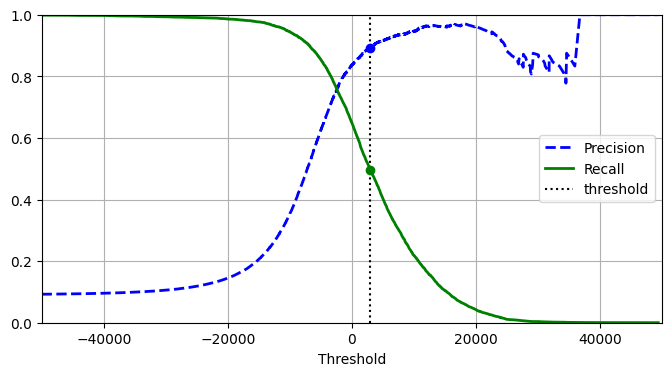

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

At this threshold value, precision is near 90% and recall is around 50%. Another way to select a good precision/recall trade-off is to plot precision directly against recall.

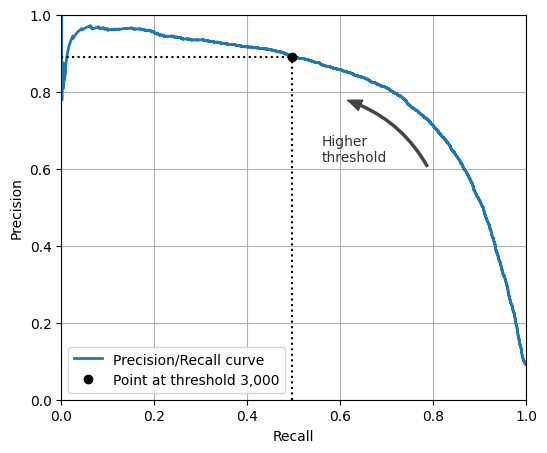

In [30]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

We can see that precision really starts to fall sharply at around 80% recall. We will probably want to select a precision/recall trade-off just before that drop-for example, at around 60% recall. But of course, the choice depends on our project.  
Suppose we decide to aim for 90% precision. We could use the first plot to find the threshold we need to use, but that's not very precise. Alternatively, we can search for the lowest threshold that gives us at least 90% precision. For this, we can use the NumPy array's argmax() method. This returns the first index of the maximum value, which in this case means the first True value:  

In [31]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifiers predict() method, we can run this code:

In [32]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Let's check these predictions precision and recall:

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

Great, we have a 90% precision classifier. As we can see, it is fairly easy to create a classifier with virtually any precision we want: just set a high enough threshold, and we're done. But wait, not so fast-a high precision classifier is not very useful if its recall is to low. For many applications, 48% recall wouldn't be great at all.

Tip: If someone says, "Let's reach 99% precision", we should ask, "At what recall?"

#### The ROC Curve  
The _receiver operating characteristic_ (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the _true positive rate_ (another name for recall) against the _false positive rate_ (FPR). The FPR (also called the _fall-out_) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the _true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specifity. Hence, the ROC curve plots _sensitivity_ (recall) versus 1 - _specifity_.  
To plot the ROC curve, we first use the roc_curve() function to compute the TPR and FPR for various threshold values:

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then we can plot the FPR against the TPR using Matplotlib. To find the point that corresponds to 90% precision, we need to look for the index of the desired threshold. Since thresholds are listed in decreasing order in this case, we use <= instead of >= on the first line:

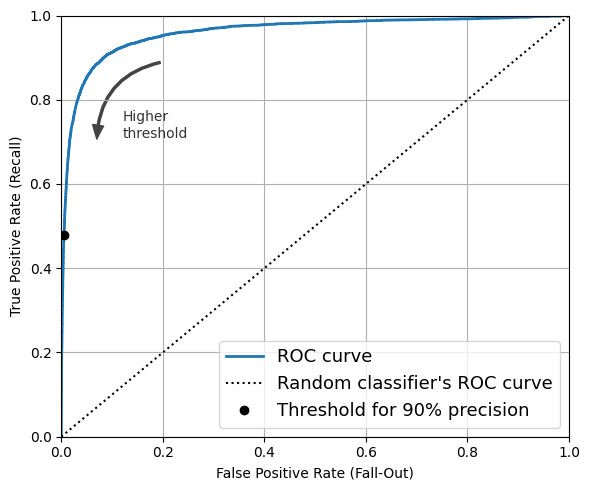

In [36]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier: a good classifier stays as far away from that line as possible (toward the top-left corner).  
One way to compare classifiers is to measure the _area under the curve_ (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the ROC AUC:  

In [37]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's now create a RandomForestClassifier, whose PR curve and $F_1$ score we can compare to those of the SGDClassifier:

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

The precision_recall_curve() function expects labels and scores for each instance, so we need to train the random forest classifier and make it assign a score to each instance. But the RandomForestClassifier class does not have a decision_function() method, due to the way it works. Luckily, it has a predict_proba() method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score, so it will work fine. We can call the cross_val_predict() function to train the RandomForestClassifier using cross-validation and make it predict class probabilities for every image as follows:

In [39]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

Let's look at the class probabilities for the first two images in the training set:

In [40]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative, the probabilities in each row add up to 100%.

The second column contains the estimated probabilities for the positive class, so let's pass them to the precision_recall_curve() function:

In [41]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

Now we're ready to plot the PR curve. It is useful to plot the first PR curve as well to see how they compare:

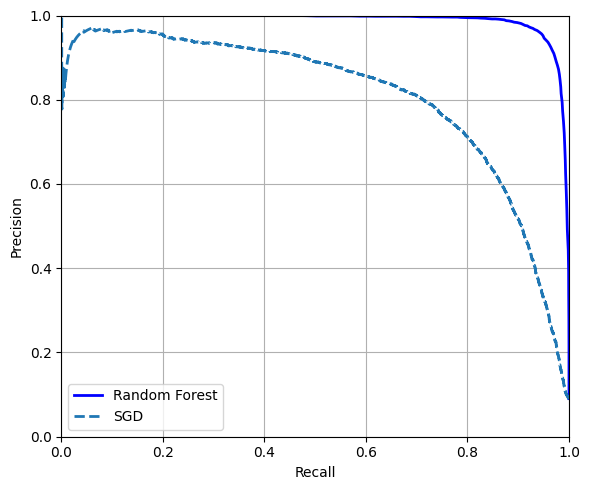

In [42]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

As you can see in the Figure, the RandomForestClassifier's PR curve looks much better than the SGDClassifier's: it comes much closer to the top-right corner. Its $F_1$ score and ROC AUC score are also significantly better:  

In [43]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 #positive proba >= 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [45]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [46]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

We have about 99.1% precision and 86.6% recall. Not too bad!  
We now know how to train binary classifiers, choose the appropiate metric for our task, evaluate our classifiers using cross-validation, select the precision/recall trade-off that fits our needs, and use several metrics and curves to compare various models. We are ready to try to detect more than just the 5s.

### Multiclass Classification  
Whereas binary classifiers distinguish between two classes, _multiclass classifiers_ (also called _multinomial classifiers_) can distinguish between more than two classes.  
Some Scikit-Learn classifiers (e.g., LogisticRegression,RandomForestClassifier, and GaussianNB) are capable of handling multiple classes natively. Others are strictly binary classifiers (e.g. SGDClassifiers and SVC). However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.  
One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, we get the decision score from each classifier for that image and we select the class whose classifier outputs the highest score. This is called the _one-versus-the-rest_ (OvR) strategy, or sometimes _one-versus-all_ (OvA).  
Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the _one-versus-one_ (OvO) strategy. If there are N classes, we need to train $\dfrac{N * (N-1)}{2} $ classifiers. For the MNIST problem, this means training 45 binary classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.

Scikit-Learn detects when we try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let's try this with a support vector machine classifier using sklearn.svm.SVC class. We'll only train on the first 2,000 images, or else it will take a very long time:

In [47]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

We trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Since there are 10 classes (i.e., more than 2). Scikit-Learn used the OvO strategy and trained 45 binary classifiers. Now let's make a prediction on an image:

In [48]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

That's correct! This code actually made 45 predictions-one per pair of classes-and it selected the class that won the most duels. If you call the decision_function() method, we will see that it returns 10 scores per instance: one per class. Each class gets a score equal to the number of won duels plus or minus a small tweak (max +- 0.33) to break ties, based on the classifier scores:

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest score is 9.3, and it's indeed the one corresponding to class 5:

In [50]:
class_id = some_digit_scores.argmax()
class_id

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In the case of the MNIST, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class '5'), but in general we won't be so lucky, we will need to look up the class label like this:

In [51]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [52]:
svm_clf.classes_[class_id]

'5'

If we want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, we can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it doesn't even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy based on an SVC:

In [53]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

Let's make a prediction, and check the number of trained classifiers:

In [54]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [55]:
len(ovr_clf.estimators_)

10

Training an SGDClassifier on a multiclass dataset and using it to make predictions is just as easy:

In [56]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

That's incorrect. Prediction errors do happen. This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The decision_function() method now returns one value per class. Let's look at the scores that the SGD classifier assigned to each class:

In [57]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

We can see that the classifier is not very confident about its prediction: almost all scores are very negative, while class 3 has a score of +1,824 and class 5 is not too far behind at -1,386. Of course, we'll want to evaluate this classifier on more than one image. Since there are roughly the same number of images in each class, the accuracy metric is fine. As usual, we can use the cross_val_score() function to evaluate the model:

In [58]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

It gets over 85.8% on all test folds. If we used a random classifier, we would get 10% accuracy, so this is not such a bad score, but we can still do much better. Simply scaling the inputs increases accuracy above 89.1%:

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis  
Let's assume that we have found a promising model and want to find ways to improve it. One way to do this is to analyze the types of errors it makes.  
First, we look at the confusion matrix. For this, we first need to make predictions using the cross_val_predict() function; then we can pass the labels and predictions to the confusion_matrix() function. However, since there are now 10 classes instead of 2, the confusion matrix will contain quite a lot of numbers, and it may be hard to read.  
A colored diagram of the confusion matrix is much easier to analyze. To plot such a diagram, use the ConfusionMatrixDisplay.from_predictions() function like this:

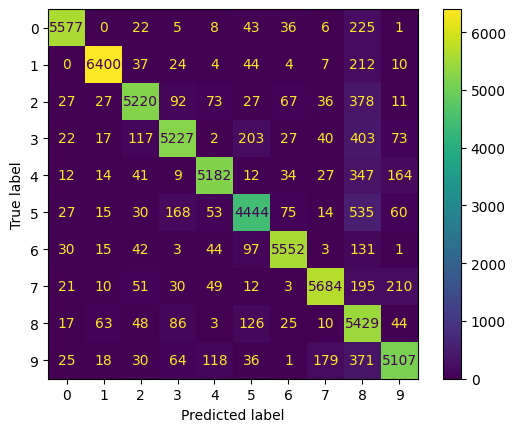

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

This confusion matrix looks pretty good: most images are on the main diagonal, which means that they were classified correctly. Notice that the cell on the diagonal in row #5 and column #5 look slightly darker than the other digits. This could be because the model made more errors on 5s, or because there are fewer 5s in the dataset than the other digits. That's why it's important to normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class (i.e., divide by the row's sum). This can be done simply by setting normalize="true". We can also specify the values_format=".0%" argument to show percentages with no decimals:

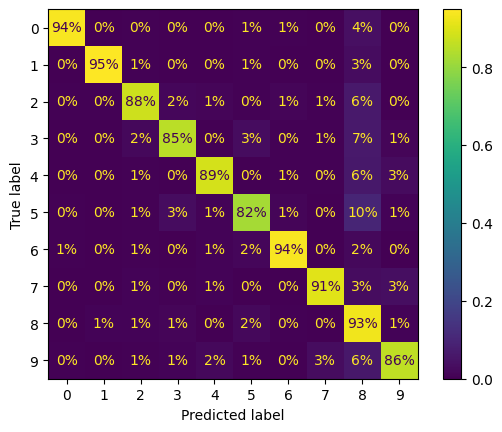

In [61]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")

Now we can easily see that only 82% of the images of 5s were classified correctly. The most common error the model made with images of 5s was to misclassify them as 8s: this happened for 10% of all 5s. But only 2% of 8s got misclassified as 5s; confusion matrices are generally not symmetrical. If we look carefully, we will notice that many digits have been misclassified as 8s, but this is not inmediately obvious from this diagram. If we want to make the errors stand out more, we can try putting zero weight on the correct predictions:

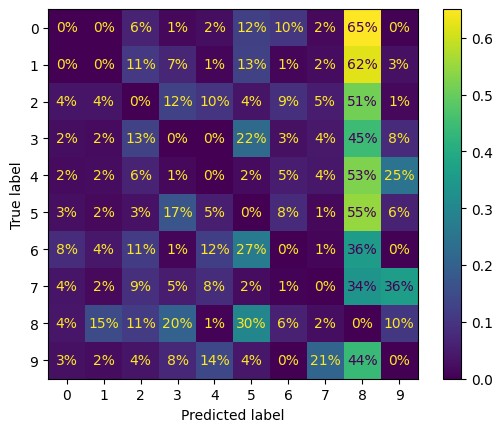

In [62]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")

Now we can see much more clearly the kinds of errors the classifier makes. The column for class 8 is now really bright, which confirms that many images got misclassified as 8s. In fact this is the most common misclassification for almost all classes.   
But we need to be careful how we interpret the percentages in this diagram: we need to remember we excluded the correct predictions. For example, the 36% in row #7, column #9 does not mean that 36% of all images of 7s were misclassified as 9s. It means that 36% of the _errors_ the model made on images of 7s were misclassifications as 9s.

It is also possible to normalize the confusion matrix by column rather than by row: if we set normalize="pred". For example, we can see that 56% of misclassified 7s are actually 9s.

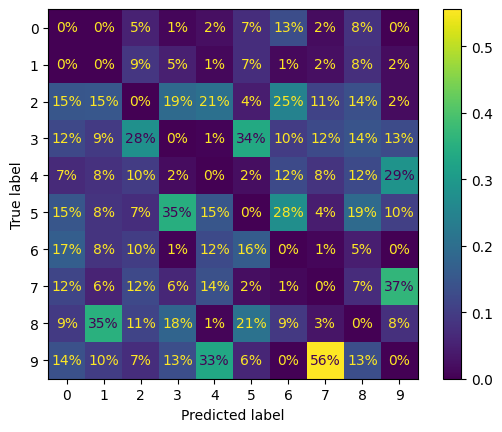

In [63]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")

Analyzing the confusion matrix often gives us insights into ways to improve our classifier. Looking at these plots, it seems that our efforts should be spent on reducing the false 8s. For example, we could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or we could engineer new features that would help the classifier- for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or we could preprocess the images to make some patterns, such as closed loops, stand out more.

Analyzing individual errors can also be a good way to gain insights into what our classifier is doing and why it is failling. For example, let's plot examples of 3s and 5s in a confussion matrix style:

In [64]:
cl_a, cl_b = '3' , '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

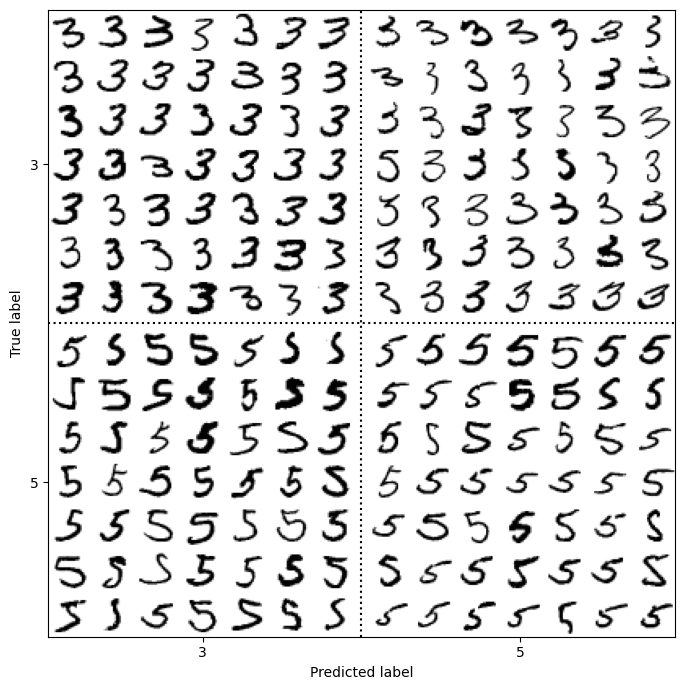

In [65]:
# extra code – this cell generates and saves Figure 3–11
size = 7
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

As we can see, some of the digits that the classifier gets wrong (i.e, in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them. However, most misclassified images seem like obvious errors to us.   
It may be hard to understand why the classifier made the mistakes it did, but remember that the human brain is a fantastic pattern recognition system, and our visual system does a lot of complex preprocessing before any information even reaches our consciousness. So the fact that this task feels simple does not mean that it is. Recall that we used a simple SGDClassifier, which is just a linear model: all it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. Since 3s and 5s differ by only a few pixels, this model will easily confuse them.  
The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If we draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation.

## Multilabel Classification  
Until now, each instance has always been assigned to just one class. But in some cases we may want our classifier to output multiple classes for each instance. Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces: Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [True, False, True] (meaning "Alice yes, Bob no, Charlie yes"). Such a classification system that outputs multiple binary tags is called a _multilabel classification system_.

Let's look at a simpler example:

In [66]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7,8 or 9) and the second indicates whether or not it is odd. Then the code creates a KNeighborClassifier instance, which supports multilabel classification (not all classifiers do), and trains this model using the multiple targets array. Now we can make a prediction, and notice that it outputs two labels:

In [67]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit is indeed not large (False) and odd (True).  
There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on our project. One approach is to measure the $F_1$ score for each individual label, then simply compute the average score. The following code computes the average $F_1$ score across all labels:

In [68]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This approach assumes that all labels are equally important, which may not be the case. In particular, if we have many more pictures of Alice than of Bob or Charlie, we may want to give more weight to the classifier's score on pictures of Alice. One simple option is to give each label a weight equal to its _support_ (i.e., the number of instances with that target label). To do this, simply set average="weighted" when calling the f1_score() function.

## Multioutput Classification  
It is a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).  
To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). This is thus an example of a multioutput classification system.  
Let's start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy's randint() function. The target images will be the original images:

In [69]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's take a peek at the first image from the test set:

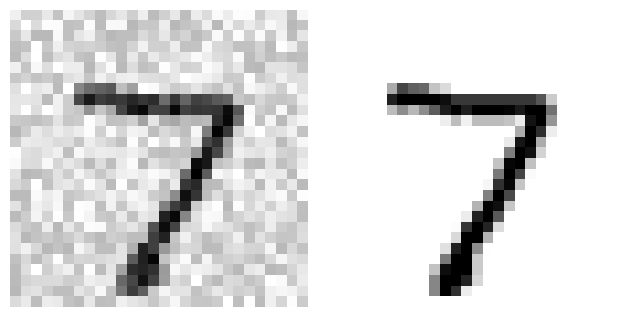

In [70]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

On the left is the noisy input image, and on the right is the clean target image. Now lets train the classifier and make it clean up this image:

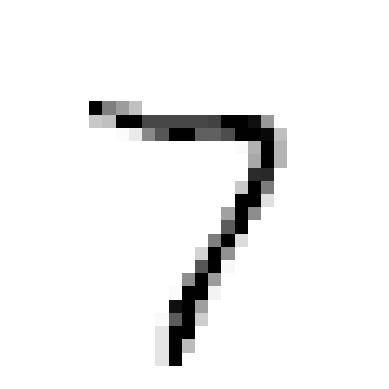

In [71]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

Looks close enough to the target!

## Exercise solutions

> Agregar bloque entrecomillado



### 1. An MNIST Classifier With Over 97% Accuracy

Exercise: _Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters)._

Let's start with a simple K-Nearest Neighbors classifier and measure its performance on the test set. This will be our baseline:

In [72]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

Great! A regular KNN classifier with the default hyperparameters is already very close to our goal.

Let's see if tuning the hyperparameters can help. To speed up the search, let's train only on the first 10,000 images:

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [74]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [75]:
grid_search.best_score_

0.9441999999999998

The score dropped, but that was expected since we only trained on 10,000 images. So let's take the best model and train it again on the full training set:

In [76]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

We reached our goal of 97% accuracy! 🥳

### 2. Data Augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

Let's try augmenting the MNIST dataset by adding slightly shifted versions of each image.

In [77]:
from scipy.ndimage import shift

In [78]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

Let's see if it works:

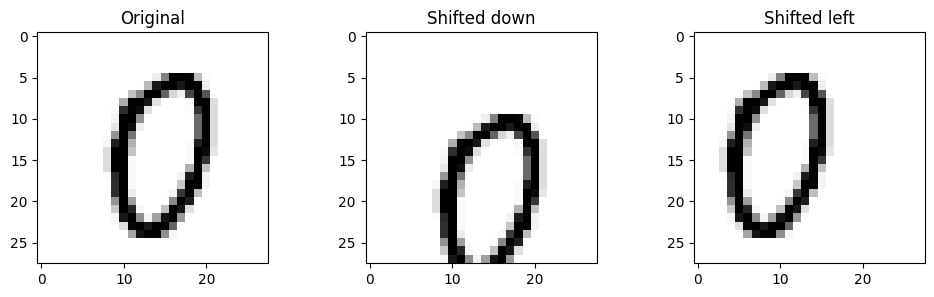

In [79]:
image = X_train[1000]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

Looks good! Now let's create an augmented training set by shifting every image left, right, up and down by one pixel:

In [80]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

Let's shuffle the augmented training set, or else all shifted images will be grouped together:

In [81]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Now let's train the model using the best hyperparameters we found in the previous exercise:

In [82]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [83]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

**Warning**: the following cell may take a few minutes to run:

In [84]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

By simply augmenting the data, we've got a 0.5% accuracy boost. Perhaps it does not sound so impressive, but it actually means that the error rate dropped significantly:

In [85]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


The error rate dropped quite a bit thanks to data augmentation.

### 3. Tackle the Titanic dataset

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

Let's fetch the data and load it:

In [86]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [87]:
train_data, test_data = load_titanic_data()

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can on the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [88]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

Let's explicitly set the `PassengerId` column as the index column:

In [89]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

Let's get more info to see how much data is missing:

In [90]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [91]:
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [92]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Yikes, only 38% **Survived**! 😭 That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [93]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [94]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [95]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [96]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Now let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

Now we can build the pipeline for the categorical attributes:

In [98]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

Note: the `sparse` hyperparameter below was renamed to `sparse_output`.

In [99]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

Finally, let's join the numerical and categorical pipelines:

In [100]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [101]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Let's not forget to get the labels:

In [102]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with a `RandomForestClassifier`:

In [103]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Great, our model is trained, let's use it to make predictions on the test set:

In [104]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format expected by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [105]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

Okay, not too bad! Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that our score is in the top 2%, woohoo! Some Kagglers reached 100% accuracy, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! 😆

Let's try an `SVC`:

In [106]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

Great! This model looks better.

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

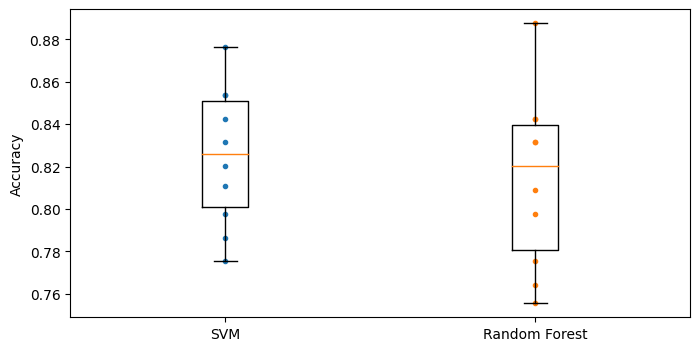

In [107]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well.

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
  * Replace **SibSp** and **Parch** with their sum.
  * Try to identify parts of names that correlate well with the **Survived** attribute.
  * Use the **Cabin** column, for example take its first letter and treat it as a categorical attribute.

In [108]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [109]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


### 4. Spam classifier

Exercise: _Build a spam classifier (a more challenging exercise):_

* _Download examples of spam and ham from [Apache SpamAssassin's public datasets](https://homl.info/spamassassin)._
* _Unzip the datasets and familiarize yourself with the data format._
* _Split the datasets into a training set and a test set._
* _Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello," "how," "are," "you," then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning [“Hello" is present, "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word._

_You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with "URL," replace all numbers with "NUMBER," or even perform _stemming_ (i.e., trim off word endings; there are Python libraries available to do this)._

_Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision._

In [110]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [111]:
ham_dir, spam_dir = fetch_spam_data()

Next, let's load all the emails:

In [112]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [113]:
len(ham_filenames)

2500

In [114]:
len(spam_filenames)

500

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [115]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [116]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [117]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [118]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [119]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [120]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [121]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [122]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [123]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [124]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

In [125]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [126]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [127]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

And this is the resulting plain text:

In [128]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [129]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [130]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Let's throw in some stemming! We will use the Natural Language Toolkit ([NLTK](http://www.nltk.org/)):

In [131]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library:

In [133]:
import sys

assert sys.version_info >= (3, 7)

In [134]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# if running this notebook on Colab or Kaggle, we just pip install urlextract
if IS_COLAB or IS_KAGGLE:
    %pip install -q -U urlextract

**Note:** inside a Jupyter notebook, always use `%pip` instead of `!pip`, as `!pip` may install the library inside the wrong environment, while `%pip` makes sure it's installed inside the currently running environment.

In [135]:
import urlextract # may require an Internet connection to download root domain
                  # names

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [136]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [137]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [138]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [139]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [140]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [141]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [142]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

0.985

Over 98.5%, not bad for a first try! :) However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [144]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 96.88%
Recall: 97.89%
